In [4]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [6]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

input_path = Path("Practise Test Case 4 Data.xlsx")
assert input_path.exists(), f"File not found: {input_path}"

# load first sheet
xls = pd.ExcelFile(input_path)
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])
outdir = Path("./eda_outputs")
outdir.mkdir(exist_ok=True)

print("Loaded", input_path, "shape:", df.shape)
print("Columns:", list(df.columns))

# ---------- Identify target ----------
possible_target_names = [c for c in df.columns if c.lower().strip() in (
    'revenue grid')]
target = possible_target_names[0] if possible_target_names else df.columns[-1]
print("Using target:", target)
print(df[target].value_counts(dropna=False))
print("Normalized:", df[target].value_counts(normalize=True))

# ---------- Basic column summary ----------
summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_missing": df.isnull().sum(),
    "n_unique": df.nunique(dropna=False)
})
summary.to_csv(outdir/"column_summary.csv")
print("Saved column summary ->", outdir/"column_summary.csv")

# ---------- numeric/categorical split ----------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in numeric_cols and c != target]

# ---------- correlation matrix ----------
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title("Correlation matrix (numeric)")
    plt.tight_layout()
    plt.savefig(outdir/"correlation_matrix.png")
    plt.close()
    print("Saved correlation_matrix.png")

# ---------- Skewness / kurtosis ----------
skew_kurt = pd.DataFrame({
    "skew": df[numeric_cols].skew().round(4),
    "kurtosis": df[numeric_cols].kurtosis().round(4),
    "min": df[numeric_cols].min(),
    "max": df[numeric_cols].max()
}).sort_values("skew", key=lambda s: s.abs(), ascending=False)
skew_kurt.to_csv(outdir/"skew_kurt_summary.csv")
print("Saved skew/kurt summary ->", outdir/"skew_kurt_summary.csv")

# ---------- Outliers via IQR ----------
out_summary = []
for c in numeric_cols:
    s = df[c].dropna()
    if s.empty: continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    n_out = ((s < lower) | (s > upper)).sum()
    out_summary.append({"feature": c, "n_non_null": s.shape[0], "n_outliers": int(n_out),
                        "lower": float(lower), "upper": float(upper)})
out_df = pd.DataFrame(out_summary).sort_values("n_outliers", ascending=False)
out_df.to_csv(outdir/"outlier_summary.csv", index=False)
print("Saved outlier summary ->", outdir/"outlier_summary.csv")

# ---------- Surprising relationships: numeric features grouped by target ----------
if target in df.columns:
    means = df.groupby(target)[numeric_cols].mean().T
    means["range"] = means.max(axis=1) - means.min(axis=1)
    top_diff = means.sort_values("range", ascending=False).head(20)
    top_diff.to_csv(outdir/"top_numeric_diffs_by_target.csv")
    print("Saved top numeric diffs by target ->", outdir/"top_numeric_diffs_by_target.csv")
    print("Top numeric features by difference (first 10):")
    print(top_diff.head(10))

# For categorical features, compute distribution per target and do chi-squared test
cat_report = []
for c in cat_cols:
    tab = pd.crosstab(df[c].fillna("<<MISSING>>"), df[target])
    if tab.shape[0] < 2 or tab.shape[1] < 2:
        continue
    try:
        chi2, p, dof, _ = stats.chi2_contingency(tab)
    except Exception:
        continue
    cat_report.append({"feature": c, "n_levels": tab.shape[0], "chi2_pvalue": p})
cat_report_df = pd.DataFrame(cat_report).sort_values("chi2_pvalue")
cat_report_df.to_csv(outdir/"categorical_chi2_report.csv", index=False)
print("Saved categorical chi2 report ->", outdir/"categorical_chi2_report.csv")
print("Top categorical features by association (lowest p-values):")
print(cat_report_df.head(10))

# ---------- Example per-class histograms for top numeric features ----------
top_num = list(top_diff.index[:6]) if (target in df.columns and not top_diff.empty) else numeric_cols[:6]
for c in top_num:
    plt.figure()
    for val in sorted(df[target].unique()):
        subset = df[df[target] == val][c].dropna()
        if subset.empty: continue
        plt.hist(subset, bins=30, alpha=0.5, label=str(val))
    plt.legend()
    plt.title(f"Histogram of {c} by {target}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(outdir/f"hist_{c}.png")
    plt.close()

print("Individual histograms saved for top numeric features.")

# ---------- Save a small sample for manual inspection ----------
df.sample(min(200, len(df))).to_csv(outdir/"sample_for_manual_inspect.csv", index=False)
print("Saved sample_for_manual_inspect.csv")

print("EDA complete. Inspect the 'eda_outputs' directory for CSVs and PNGs.")


Loaded Practise Test Case 4 Data.xlsx shape: (10155, 31)
Columns: ['REF_NO', 'children', 'age_band', 'status', 'occupation', 'occupation_partner', 'home_status', 'family_income', 'self_employed', 'self_employed_partner', 'year_last_moved', 'post_code', 'post_area', 'Average Credit Card Transaction', 'Balance Transfer', 'Term Deposit', 'Life Insurance', 'Medical Insurance', 'Average A/C Balance', 'Personal Loan', 'Investment in Mutual Fund', 'Investment Tax Saving Bond', 'Home Loan', 'Online Purchase Amount', 'Revenue Grid', 'gender', 'region', 'Investment in Commodity', 'Investment in Equity', 'Investment in Derivative', 'Portfolio Balance']
Using target: Revenue Grid
Revenue Grid
2    9069
1    1086
Name: count, dtype: int64
Normalized: Revenue Grid
2    0.893058
1    0.106942
Name: proportion, dtype: float64
Saved column summary -> eda_outputs/column_summary.csv
Saved correlation_matrix.png
Saved skew/kurt summary -> eda_outputs/skew_kurt_summary.csv
Saved outlier summary -> eda_outp

In [86]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import re
# import numpy as np

# # Load dataset
# file_path = "Practise Test Case 4 Data.xlsx"
# xls = pd.ExcelFile(file_path)
# df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# # Identify target column
# target = [c for c in df.columns if c.lower().strip() in ['revenue grid', 'revenue_grid', 'target', 'label']]
# target = target[0] if target else df.columns[-1]

# # Define clusters
# investment_cluster = ['Investment in Commodity', 'Investment in Equity', 'Investment in Derivative', 'Portfolio Balance']
# deposit_balance_cluster = ['Average A/C Balance', 'Term Deposit', 'Balance Transfer', 'Average Credit Card Transaction']
# insurance_loan_cluster = ['Life Insurance', 'Medical Insurance', 'Personal Loan', 'Home Loan']

# # Keep only existing columns
# investment_cluster = [c for c in investment_cluster if c in df.columns]
# deposit_balance_cluster = [c for c in deposit_balance_cluster if c in df.columns]
# insurance_loan_cluster = [c for c in insurance_loan_cluster if c in df.columns]

# # Convert numeric columns
# for col in investment_cluster + deposit_balance_cluster + insurance_loan_cluster:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# # Safe filename function
# def safe_filename(name):
#     return re.sub(r'[^A-Za-z0-9_]+', '_', name)

# # Plotting function
# def plot_cluster_distributions(cluster_cols, cluster_name):
#     melted = df.melt(id_vars=[target], value_vars=cluster_cols, var_name='Feature', value_name='Value')

#     # Boxplot comparison
#     plt.figure(figsize=(12, 6))
#     sns.boxplot(data=melted, x='Feature', y='Value', hue=target)
#     plt.title(f"{cluster_name} Distribution by {target}")
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.savefig(f"{safe_filename(cluster_name)}_boxplot.png")
#     plt.close()

#     # Histograms for each feature by class
#     for col in cluster_cols:
#         plt.figure(figsize=(8, 5))
#         for cls in df[target].unique():
#             subset = df[df[target] == cls][col].dropna()
#             plt.hist(subset, bins=30, alpha=0.5, label=f"{target}={cls}", density=True)
#         plt.title(f"{col} - Distribution by {target}")
#         plt.xlabel(col)
#         plt.ylabel("Density")
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f"/mnt/data/{safe_filename(col)}_hist.png")
#         plt.close()

# # Generate plots
# if investment_cluster:
#     plot_cluster_distributions(investment_cluster, "Investment Cluster")
# if deposit_balance_cluster:
#     plot_cluster_distributions(deposit_balance_cluster, "Deposit–Balance Cluster")
# if insurance_loan_cluster:
#     plot_cluster_distributions(insurance_loan_cluster, "Insurance–Loan Cluster")

# # Mean summary for quick comparison
# summary = pd.DataFrame({
#     "Investment Cluster Mean": df.groupby(target)[investment_cluster].mean().mean(axis=1) if investment_cluster else None,
#     "Deposit–Balance Cluster Mean": df.groupby(target)[deposit_balance_cluster].mean().mean(axis=1) if deposit_balance_cluster else None,
#     "Insurance–Loan Cluster Mean": df.groupby(target)[insurance_loan_cluster].mean().mean(axis=1) if insurance_loan_cluster else None
# })

# print("All cluster comparison graphs saved to /mnt/data/")
# print("File names sanitized (slashes replaced with underscores).")
# print("Summary statistics for cluster means below:")

# print(summary)
# summary.to_csv("cluster_mean_summary.csv")


In [88]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # ---------- Load dataset ----------
# file_path = "Practise Test Case 4 Data.xlsx"
# xls = pd.ExcelFile(file_path)
# df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# # ---------- Identify target ----------
# target = [c for c in df.columns if c.lower().strip() in 
#           ['revenue grid', ]]
# target = target[0] if target else df.columns[-1]

# # ---------- Define clusters ----------
# investment_cluster = ['Investment in Commodity', 'Investment in Equity', 
#                       'Investment in Derivative', 'Portfolio Balance']
# deposit_balance_cluster = ['Average A/C Balance', 'Term Deposit', 
#                            'Balance Transfer', 'Average Credit Card Transaction']
# insurance_loan_cluster = ['Life Insurance', 'Medical Insurance', 
#                           'Personal Loan', 'Home Loan']

# # Keep only columns present in dataset
# investment_cluster = [c for c in investment_cluster if c in df.columns]
# deposit_balance_cluster = [c for c in deposit_balance_cluster if c in df.columns]
# insurance_loan_cluster = [c for c in insurance_loan_cluster if c in df.columns]

# # Convert to numeric
# for col in investment_cluster + deposit_balance_cluster + insurance_loan_cluster:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# df[target] = df[target].astype(str)

# # ---------- Compute means ----------
# grouped = df.groupby(target).mean(numeric_only=True)
# classes = sorted(df[target].unique())
# if len(classes) < 2:
#     raise ValueError(f"Expected at least two target classes, found {classes}")

# # Helper to get cluster means for a given class
# def cluster_means(cls):
#     return {
#         "Investment": [grouped.loc[cls, c] for c in investment_cluster],
#         "DepositBalance": [grouped.loc[cls, c] for c in deposit_balance_cluster],
#         "InsuranceLoan": [grouped.loc[cls, c] for c in insurance_loan_cluster],
#     }

# means = {cls: cluster_means(cls) for cls in classes[:2]}

# # ---------- Consistent scale ----------
# max_val = 0
# for cls in means:
#     for cluster_vals in means[cls].values():
#         total = np.sum(np.nan_to_num(cluster_vals))
#         max_val = max(max_val, total)
# ymax = max_val * 1.15

# # ---------- Plotting ----------
# fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
# cluster_labels = ["Investment", "Deposit–Balance", "Insurance–Loan"]

# for i, cls in enumerate(classes[:2]):
#     ax = axes[i]
#     x = np.arange(len(cluster_labels))
#     bottoms = np.zeros(len(x))

#     # Plot stacked bars
#     feature_labels = []
#     for cluster, feature_list in zip(cluster_labels, 
#                                      [investment_cluster, deposit_balance_cluster, insurance_loan_cluster]):
#         vals = means[cls][cluster.replace('–','').replace('-','')]
#         # Align stacks per feature
#         for j, val in enumerate(vals):
#             bar_height = val if not np.isnan(val) else 0
#             ax.bar(cluster, bar_height, bottom=bottoms[list(cluster_labels).index(cluster)])
#             bottoms[list(cluster_labels).index(cluster)] += bar_height
#             feature_labels.append(feature_list[j])

#     # Add text annotations (cluster totals)
#     for k, total in enumerate(bottoms):
#         ax.text(k, total + ymax * 0.01, f"{total:.0f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

#     ax.set_title(f"Target Class = {cls}", fontsize=13)
#     ax.set_ylabel("Mean Value")
#     ax.set_ylim(0, ymax)
#     ax.grid(axis='y', linestyle='--', alpha=0.6)

# fig.suptitle("Cluster Mean Stacked Comparison by Target Class", fontsize=15, fontweight='bold')
# plt.tight_layout()
# plt.show()


In [90]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # ---------- Load dataset ----------
# file_path = "Practise Test Case 4 Data.xlsx"
# xls = pd.ExcelFile(file_path)
# df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# # ---------- Identify target ----------
# target = [c for c in df.columns if c.lower().strip() in 
#           ['revenue grid', 'revenue_grid', 'target', 'label']]
# target = target[0] if target else df.columns[-1]

# # ---------- Define clusters ----------
# investment_cluster = ['Investment in Commodity', 'Investment in Equity', 
#                       'Investment in Derivative', 'Portfolio Balance']
# deposit_balance_cluster = ['Average A/C Balance', 'Term Deposit', 
#                            'Balance Transfer', 'Average Credit Card Transaction']
# insurance_loan_cluster = ['Life Insurance', 'Medical Insurance', 
#                           'Personal Loan', 'Home Loan']

# # Keep only columns present in dataset
# investment_cluster = [c for c in investment_cluster if c in df.columns]
# deposit_balance_cluster = [c for c in deposit_balance_cluster if c in df.columns]
# insurance_loan_cluster = [c for c in insurance_loan_cluster if c in df.columns]

# # Convert numeric
# for col in investment_cluster + deposit_balance_cluster + insurance_loan_cluster:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# df[target] = df[target].astype(str)

# # ---------- Compute means ----------
# grouped = df.groupby(target).mean(numeric_only=True)
# classes = sorted(df[target].unique())

# # Helper to get cluster means
# def cluster_means(cls):
#     return {
#         "Investment": [grouped.loc[cls, c] for c in investment_cluster],
#         "DepositBalance": [grouped.loc[cls, c] for c in deposit_balance_cluster],
#         "InsuranceLoan": [grouped.loc[cls, c] for c in insurance_loan_cluster],
#     }

# means = {cls: cluster_means(cls) for cls in classes[:2]}

# # ---------- Create color map ----------
# all_features = investment_cluster + deposit_balance_cluster + insurance_loan_cluster
# colors = plt.cm.tab20(np.linspace(0, 1, len(all_features)))  # 20 distinct colors
# feature_colors = dict(zip(all_features, colors))

# # ---------- Consistent y-axis ----------
# max_val = 0
# for cls in means:
#     for cluster_vals in means[cls].values():
#         total = np.sum(np.nan_to_num(cluster_vals))
#         max_val = max(max_val, total)
# ymax = max_val * 1.15

# # ---------- Plot ----------
# fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
# cluster_labels = ["Investment", "Deposit–Balance", "Insurance–Loan"]

# for i, cls in enumerate(classes[:2]):
#     ax = axes[i]
#     x = np.arange(len(cluster_labels))
#     bottoms = np.zeros(len(x))

#     # Iterate through clusters
#     for cluster_idx, (cluster_name, feature_list) in enumerate(zip(
#         cluster_labels, [investment_cluster, deposit_balance_cluster, insurance_loan_cluster]
#     )):
#         for j, feature in enumerate(feature_list):
#             val = means[cls][cluster_name.replace('–', '').replace('-', '')][j]
#             val = 0 if np.isnan(val) else val
#             ax.bar(cluster_name, val, bottom=bottoms[cluster_idx],
#                    color=feature_colors[feature])
#             bottoms[cluster_idx] += val

#     # Add total labels on top
#     for k, total in enumerate(bottoms):
#         ax.text(k, total + ymax * 0.01, f"{total:.0f}",
#                 ha='center', va='bottom', fontsize=10, fontweight='bold')

#     ax.set_title(f"Target Class = {cls}", fontsize=13, weight='bold')
#     ax.set_ylabel("Mean Value")
#     ax.set_ylim(0, ymax)
#     ax.grid(axis='y', linestyle='--', alpha=0.5)

# # ---------- Add shared legend ----------
# handles = [plt.Rectangle((0, 0), 1, 1, color=feature_colors[f]) for f in all_features]
# fig.legend(handles, all_features, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# fig.suptitle("Stacked Cluster Comparison by Target Class\n(Color = Feature)", fontsize=15, fontweight='bold')
# plt.tight_layout(rect=[0, 0.1, 1, 0.95])
# plt.show()


In [92]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import FancyBboxPatch

# # ---------- Load dataset ----------
# file_path = "Practise Test Case 4 Data.xlsx"
# xls = pd.ExcelFile(file_path)
# df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# # ---------- Identify target ----------
# target = [c for c in df.columns if c.lower().strip() in 
#           ['revenue grid', 'revenue_grid', 'target', 'label']]
# target = target[0] if target else df.columns[-1]

# # ---------- Define clusters ----------
# investment_cluster = ['Investment in Commodity', 'Investment in Equity', 
#                       'Investment in Derivative', 'Portfolio Balance']
# deposit_balance_cluster = ['Average A/C Balance', 'Term Deposit', 
#                            'Balance Transfer', 'Average Credit Card Transaction']
# insurance_loan_cluster = ['Life Insurance', 'Medical Insurance', 
#                           'Personal Loan', 'Home Loan']

# # Keep only existing columns
# investment_cluster = [c for c in investment_cluster if c in df.columns]
# deposit_balance_cluster = [c for c in deposit_balance_cluster if c in df.columns]
# insurance_loan_cluster = [c for c in insurance_loan_cluster if c in df.columns]

# # Convert to numeric
# for col in investment_cluster + deposit_balance_cluster + insurance_loan_cluster:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# df[target] = df[target].astype(str)

# # ---------- Compute means ----------
# grouped = df.groupby(target).mean(numeric_only=True)
# classes = sorted(df[target].unique())

# def cluster_means(cls):
#     return {
#         "Investment": [grouped.loc[cls, c] for c in investment_cluster],
#         "DepositBalance": [grouped.loc[cls, c] for c in deposit_balance_cluster],
#         "InsuranceLoan": [grouped.loc[cls, c] for c in insurance_loan_cluster],
#     }

# means = {cls: cluster_means(cls) for cls in classes[:2]}

# # ---------- Color Palette ----------
# all_features = investment_cluster + deposit_balance_cluster + insurance_loan_cluster
# colors = plt.cm.Set2(np.linspace(0, 1, len(all_features)))  # pleasant soft colors
# feature_colors = dict(zip(all_features, colors))

# # ---------- Setup ----------
# fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True, facecolor="#f8f9fa")
# cluster_labels = ["Investment", "Deposit–Balance", "Insurance–Loan"]

# # Determine max y for consistent scale
# max_val = 0
# for cls in means:
#     for cluster_vals in means[cls].values():
#         total = np.sum(np.nan_to_num(cluster_vals))
#         max_val = max(max_val, total)
# ymax = max_val * 1.2

# # ---------- Draw Stacked Bars ----------
# for i, cls in enumerate(classes[:2]):
#     ax = axes[i]
#     x = np.arange(len(cluster_labels))
#     bottoms = np.zeros(len(x))

#     for cluster_idx, (cluster_name, feature_list) in enumerate(zip(
#         cluster_labels, [investment_cluster, deposit_balance_cluster, insurance_loan_cluster]
#     )):
#         for j, feature in enumerate(feature_list):
#             val = means[cls][cluster_name.replace('–', '').replace('-', '')][j]
#             val = 0 if np.isnan(val) else val
#             bar_color = feature_colors[feature]

#             rect = ax.bar(cluster_name, val, bottom=bottoms[cluster_idx],
#                           color=bar_color, edgecolor='white', linewidth=1.2)
#             bottoms[cluster_idx] += val

#             # Percentage label inside each segment (if > 5% of total)
#             cluster_total = np.sum(np.nan_to_num(means[cls][cluster_name.replace('–', '').replace('-', '')]))
#             perc = (val / cluster_total * 100) if cluster_total > 0 else 0
#             if perc > 5:
#                 ax.text(cluster_idx, bottoms[cluster_idx] - val/2, f"{perc:.0f}%", 
#                         ha='center', va='center', fontsize=9, color='black', weight='semibold')

#     # Add total labels on top
#     for k, total in enumerate(bottoms):
#         ax.text(k, total + ymax * 0.02, f"{total:.0f}", ha='center', va='bottom', 
#                 fontsize=11, fontweight='bold', color='#333333')

#     ax.set_title(f"Class {cls}", fontsize=14, fontweight='bold', color='#212529')
#     ax.set_ylim(0, ymax)
#     ax.set_ylabel("Mean Value", fontsize=12, fontweight='bold')
#     ax.set_facecolor("#ffffff")
#     ax.grid(axis='y', linestyle='--', alpha=0.4)
#     ax.tick_params(axis='x', labelsize=11, rotation=15)

# # ---------- Legend ----------
# handles = [plt.Rectangle((0, 0), 1, 1, color=feature_colors[f]) for f in all_features]
# fig.legend(handles, all_features, loc='lower center', ncol=3, 
#            bbox_to_anchor=(0.5, -0.05), fontsize=10, frameon=False)

# # ---------- Titles ----------
# fig.suptitle("📊 Cluster Composition Comparison Between Revenue Classes\n(Color = Feature, Labels = % contribution within cluster)",
#              fontsize=16, fontweight='bold', color='#2b2b2b')
# plt.tight_layout(rect=[0, 0.1, 1, 0.95])
# plt.show()


Saved image to: properties/cluster_comparison.png


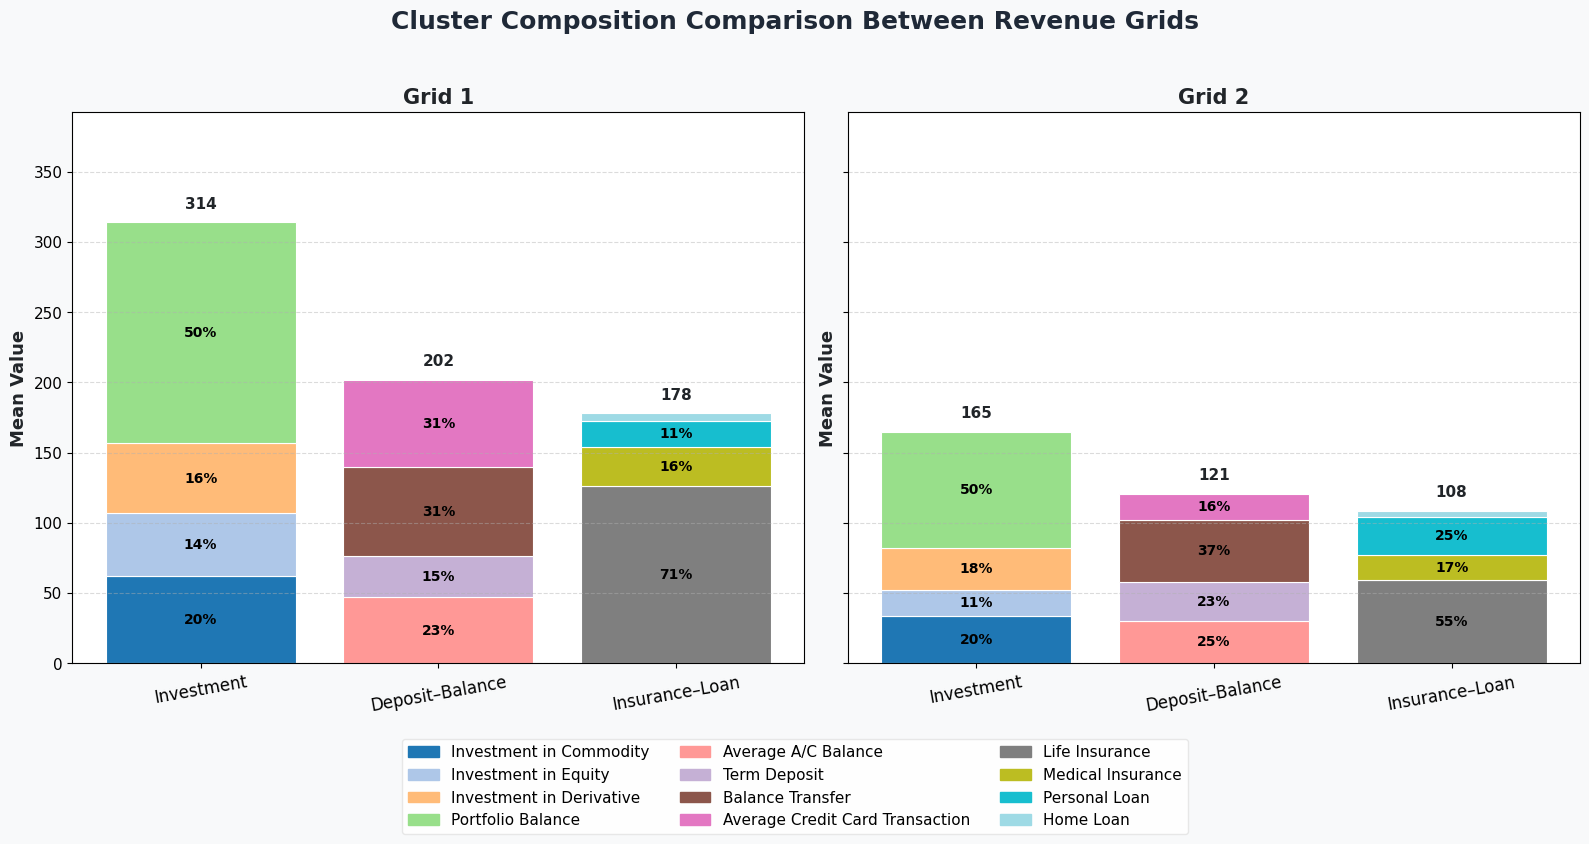

In [110]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.filterwarnings("ignore")

# ---------- Load dataset ----------
file_path = "Practise Test Case 4 Data.xlsx"
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# ---------- Identify target ----------
target = [c for c in df.columns if c.lower().strip() in 
          ['revenue grid', 'revenue_grid', 'target', 'label']]
target = target[0] if target else df.columns[-1]

# ---------- Define clusters ----------
investment_cluster = ['Investment in Commodity', 'Investment in Equity', 
                      'Investment in Derivative', 'Portfolio Balance']
deposit_balance_cluster = ['Average A/C Balance', 'Term Deposit', 
                           'Balance Transfer', 'Average Credit Card Transaction']
insurance_loan_cluster = ['Life Insurance', 'Medical Insurance', 
                          'Personal Loan', 'Home Loan']

# Keep only existing columns
investment_cluster = [c for c in investment_cluster if c in df.columns]
deposit_balance_cluster = [c for c in deposit_balance_cluster if c in df.columns]
insurance_loan_cluster = [c for c in insurance_loan_cluster if c in df.columns]

# Convert to numeric
for col in investment_cluster + deposit_balance_cluster + insurance_loan_cluster:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure target as string for grouping
df[target] = df[target].astype(str)

# ---------- Compute means ----------
grouped = df.groupby(target).mean(numeric_only=True)
classes = sorted(df[target].unique())

def cluster_means(cls):
    return {
        "Investment": [grouped.loc[cls, c] for c in investment_cluster],
        "DepositBalance": [grouped.loc[cls, c] for c in deposit_balance_cluster],
        "InsuranceLoan": [grouped.loc[cls, c] for c in insurance_loan_cluster],
    }

# If there are more than two classes, keep plotting first two (as original)
plot_classes = classes[:2]
means = {cls: cluster_means(cls) for cls in plot_classes}

# ---------- Colors and style ----------
all_features = investment_cluster + deposit_balance_cluster + insurance_loan_cluster
colors = plt.cm.tab20(np.linspace(0, 1, max(1, len(all_features))))
feature_colors = dict(zip(all_features, colors))

# Matplotlib style tweaks for clarity
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans", "Arial"],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
})

# ---------- Setup figure ----------
fig, axes = plt.subplots(1, len(plot_classes), figsize=(16, 8), sharey=True, facecolor="#f8f9fa")
if len(plot_classes) == 1:
    axes = [axes]  # ensure iterable

cluster_labels = ["Investment", "Deposit–Balance", "Insurance–Loan"]

# Determine consistent y-axis maximum
max_val = 0
for cls in means:
    for cluster_vals in means[cls].values():
        total = np.nansum(cluster_vals)
        max_val = max(max_val, total)
ymax = max_val * 1.25 if max_val > 0 else 1.0

# ---------- Plotting ----------
for i, cls in enumerate(plot_classes):
    ax = axes[i]
    x_positions = np.arange(len(cluster_labels))
    bottoms = np.zeros(len(x_positions))

    for cluster_idx, (cluster_name, feature_list) in enumerate(zip(
        cluster_labels, [investment_cluster, deposit_balance_cluster, insurance_loan_cluster]
    )):
        # map cluster_name to the key used in means
        cluster_key = cluster_name.replace('–', '').replace('-', '')
        for j, feature in enumerate(feature_list):
            # safe extraction and nan handling
            try:
                val = means[cls][cluster_key][j]
            except Exception:
                val = 0
            val = 0 if np.isnan(val) else float(val)

            bar_color = feature_colors.get(feature, "#777777")
            ax.bar(cluster_name, val, bottom=bottoms[cluster_idx],
                   color=bar_color, edgecolor='white', linewidth=0.8)
            bottoms[cluster_idx] += val

            # Percentage label inside each stack segment (only if significant)
            cluster_total = np.nansum(means[cls][cluster_key])
            perc = (val / cluster_total * 100) if cluster_total > 0 else 0
            if perc > 5 and val > 0:
                ax.text(cluster_idx, bottoms[cluster_idx] - val/2, f"{perc:.0f}%",
                        ha='center', va='center', fontsize=10, color='black', weight='bold')

    # Add total labels above each cluster
    for k, total in enumerate(bottoms):
        ax.text(k, total + ymax * 0.02, f"{total:.0f}", ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='#212529')

    ax.set_title(f"Grid {cls}", fontsize=15, fontweight='bold', color='#212529')
    ax.set_ylim(0, ymax)
    ax.set_ylabel("Mean Value", fontsize=13, fontweight='bold', color='#212529')
    ax.set_facecolor("#ffffff")
    ax.grid(axis='y', linestyle='--', alpha=0.45)
    ax.tick_params(axis='x', labelsize=12, rotation=10)

# ---------- Legend ----------
# Create legend handles for features that are present
handles = [plt.Rectangle((0, 0), 1, 1, color=feature_colors[f]) for f in all_features]
legend = fig.legend(handles, all_features, loc='lower center', ncol=3,
           bbox_to_anchor=(0.5, -0.06), fontsize=11, frameon=True)
legend.get_frame().set_edgecolor("#e6e6e6")
legend.get_frame().set_alpha(0.95)
legend._legend_box.align = "left"

# ---------- Titles & Style ----------
fig.suptitle(
    "Cluster Composition Comparison Between Revenue Grids",
    fontsize=18, fontweight='bold', color='#1f2937'
)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])

# ---------- Save to properties folder ----------
out_dir = "properties"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "cluster_comparison.png")
fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"Saved image to: {out_path}")

plt.show()


✅ Saved chart with legend to: properties/online_purchase.png


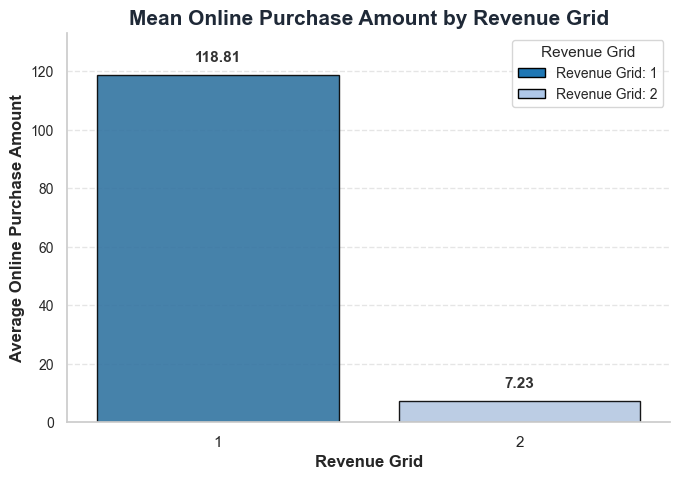

In [118]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# ---------- CONFIG ----------
column = "Online Purchase Amount"  # 👈 change this to your column
file_path = "Practise Test Case 4 Data.xlsx"
# ----------------------------

# Load dataset
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# Identify target
target_candidates = [c for c in df.columns if c.lower().strip() in 
                     ['revenue grid', 'revenue_grid', 'target', 'label']]
target = target_candidates[0] if target_candidates else df.columns[-1]
df[target] = df[target].astype(str)

# Ensure numeric
if column not in df.columns:
    raise ValueError(f"Column '{column}' not found in dataset.")
df[column] = pd.to_numeric(df[column], errors='coerce')

# Compute means and standard error
group_means = df.groupby(target)[column].mean()
group_stds = df.groupby(target)[column].std()
group_counts = df.groupby(target)[column].count()
group_sem = group_stds / np.sqrt(group_counts)

# ---------- Plot ----------
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(figsize=(7, 5))

palette = sns.color_palette("tab20", len(group_means))

bars = sns.barplot(
    x=target,
    y=column,
    data=df,
    errorbar=None,
    palette=palette,
    hue=target,
    legend=False,
    edgecolor='black',
    alpha=0.9,
    ax=ax
)

# Add numeric labels on bars
ymax = group_means.max()
padding = ymax * 0.12
for i, cls in enumerate(group_means.index):
    ax.text(
        i, group_means[cls] + ymax * 0.03,
        f"{group_means[cls]:.2f}",
        ha='center', va='bottom',
        fontsize=11, fontweight='bold', color="#333333"
    )

# ---------- Add Legend ----------
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i], ec='black') for i in range(len(group_means))]
ax.legend(handles, [f"{target}: {cls}" for cls in group_means.index],
          title="Revenue Grid", loc='upper right',
          frameon=True, facecolor="white", edgecolor="#cccccc",
          fontsize=10, title_fontsize=11)

# ---------- Styling ----------
ax.set_title(f"Mean {column} by {target}", fontsize=15, fontweight='bold', color="#1f2937")
ax.set_ylabel(f"Average {column}", fontsize=12, fontweight='bold')
ax.set_xlabel(target, fontsize=12, fontweight='bold')
ax.set_ylim(0, ymax + padding)
ax.set_facecolor("#ffffff")
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=10)
sns.despine()

plt.tight_layout()

# ---------- Save to properties folder ----------
out_dir = "properties"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "online_purchase.png")
fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"✅ Saved chart with legend to: {out_path}")

plt.show()


In [124]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib.patches as mpatches

# ---------- CONFIG ----------
file_path = "Practise Test Case 4 Data.xlsx"
current_year = datetime.now().year
OUT_DIR = "properties"
os.makedirs(OUT_DIR, exist_ok=True)
# ----------------------------

# Load dataset
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# Detect target
target_candidates = [c for c in df.columns if c.lower().strip() in 
                     ['revenue grid', 'revenue_grid', 'target', 'label']]
target = target_candidates[0] if target_candidates else df.columns[-1]
df[target] = df[target].astype(str)

# Prepare consistent hue ordering and palette
unique_classes = sorted(df[target].dropna().unique(), key=lambda x: str(x))
n_classes = len(unique_classes)
base_palette = sns.color_palette("tab20", n_classes)
palette_map = {cls: base_palette[i] for i, cls in enumerate(unique_classes)}
hue_order = unique_classes  # explicit ordering for hue

# Identify relevant columns (if exist)
age_band_col = [c for c in df.columns if 'age' in c.lower() and 'band' in c.lower()]
income_col = [c for c in df.columns if 'income' in c.lower()]
year_moved_col = [c for c in df.columns if 'year' in c.lower() and 'moved' in c.lower()]

age_band = age_band_col[0] if age_band_col else None
income = income_col[0] if income_col else None
year_moved = year_moved_col[0] if year_moved_col else None

# Compute Years Since Moved
if year_moved:
    df['Years Since Moved'] = current_year - pd.to_numeric(df[year_moved], errors='coerce')
else:
    print("⚠️ 'year_last_moved' column not found — skipping that feature.")

sns.set(style="whitegrid")
palette = [palette_map[cls] for cls in hue_order]

# ---------- Legend placement helper ----------
def place_legend(fig, ax, palette_map, hue_order):
    """
    Create legend handles from palette_map and place legend intelligently:
    - If few classes (<=3): place to the right (vertical).
    - If many classes: place below as a centered multi-column legend.
    """
    handles = [mpatches.Patch(color=palette_map[cls], label=f"{cls}") for cls in hue_order]
    n = len(hue_order)
    if n <= 3:
        # right side legend
        ax.legend(handles=handles, title=target, loc='upper left',
                  bbox_to_anchor=(1.03, 1), frameon=True)
        # make room on the right
        fig.subplots_adjust(right=0.75)
    else:
        # below legend, multi-column
        cols = min(n, 4)
        fig.subplots_adjust(bottom=0.18)
        fig.legend(handles=handles, title=target, loc='lower center',
                   bbox_to_anchor=(0.5, -0.02), ncol=cols, frameon=True)
    # style legend frame
    for legend in fig.legends:
        legend.get_frame().set_edgecolor("#cccccc")
        for text in legend.get_texts():
            text.set_fontsize(10)
        legend.set_title(title=target, prop={'size':11, 'weight':'bold'})

# ---------- 1️⃣ AGE BAND DISTRIBUTION ----------
if age_band:
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.countplot(x=age_band, hue=target, data=df, palette=palette_map, hue_order=hue_order,
                  ax=ax, edgecolor='black')
    ax.set_title("Age Band Distribution by Revenue Grid", fontsize=14, fontweight='bold')
    ax.set_xlabel("Age Band", fontsize=12)
    ax.set_ylabel("Count of Customers", fontsize=12)
    ax.tick_params(axis='x', rotation=15)

    place_legend(fig, ax, palette_map, hue_order)

    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, "age_band_distribution.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    print(f"Saved Age Band Distribution to: {out_path}")
    plt.close(fig)
else:
    print("⚠️ No 'Age Band' column found — skipping that chart.")

# ---------- 2️⃣ FAMILY INCOME DISTRIBUTION ----------
if income:
    # If numeric, bin it
    if pd.api.types.is_numeric_dtype(df[income]):
        df['Income Band'] = pd.cut(df[income], bins=5, precision=0)
        plot_income_col = 'Income Band'
    else:
        plot_income_col = income

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(x=plot_income_col, hue=target, data=df, palette=palette_map, hue_order=hue_order,
                  ax=ax, edgecolor='black')
    ax.set_title("Family Income Distribution by Revenue Grid", fontsize=14, fontweight='bold')
    ax.set_xlabel("Family Income Band", fontsize=12)
    ax.set_ylabel("Count of Customers", fontsize=12)
    ax.tick_params(axis='x', rotation=15)

    place_legend(fig, ax, palette_map, hue_order)

    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, "family_income_distribution.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    print(f"Saved Family Income Distribution to: {out_path}")
    plt.close(fig)
else:
    print("⚠️ No 'Family Income' column found — skipping that chart.")

# ---------- 3️⃣ YEARS SINCE MOVED COMPARISON ----------
if 'Years Since Moved' in df.columns:
    col = 'Years Since Moved'
    df[col] = pd.to_numeric(df[col], errors='coerce')
    means = df.groupby(target)[col].mean()
    ymax = (means.max() * 1.2) if means.max() > 0 else 1.0

    # Bar chart for mean years since moved
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.barplot(x=target, y=col, data=df, palette=palette_map, order=hue_order,
                ax=ax, edgecolor='black', ci=None)
    for i, cls in enumerate(hue_order):
        if cls in means.index:
            ax.text(i, means[cls] + ymax * 0.03, f"{means[cls]:.1f} yrs",
                     ha='center', fontsize=11, fontweight='bold')
    ax.set_ylim(0, ymax)
    ax.set_title("Average Tenure (Years Since Last Moved) by Revenue Grid", fontsize=14, fontweight='bold')
    ax.set_ylabel("Years Since Moved", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    place_legend(fig, ax, palette_map, hue_order)

    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, "years_since_moved_mean.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    print(f"Saved Years-Since-Moved Mean to: {out_path}")
    plt.close(fig)

    # Boxplot for distribution
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.boxplot(x=target, y=col, data=df, palette=palette_map, order=hue_order, showfliers=True, ax=ax)
    ax.set_title("Distribution of Years Since Moved across Revenue Grids", fontsize=14, fontweight='bold')
    ax.set_ylabel("Years Since Moved", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    place_legend(fig, ax, palette_map, hue_order)

    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, "years_since_moved_boxplot.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    print(f"Saved Years-Since-Moved Boxplot to: {out_path}")
    plt.close(fig)

    # Optional: t-test between first two classes (if at least 2)
    if len(hue_order) >= 2:
        a = hue_order[0]
        b = hue_order[1]
        s1 = df[df[target]==a][col].dropna()
        s2 = df[df[target]==b][col].dropna()
        if len(s1) > 2 and len(s2) > 2:
            t, p = stats.ttest_ind(s1, s2, equal_var=False)
            diff = s1.mean() - s2.mean()
            print(f"\n🧮 T-test Results for '{col}':")
            print(f"  Mean {a}: {s1.mean():.2f}, Mean {b}: {s2.mean():.2f}")
            print(f"  Mean difference: {diff:.2f}")
            print(f"  t = {t:.3f}, p = {p:.3e}")
            if p < 0.05:
                print("  ✅ Statistically significant difference between the two classes.")
            else:
                print("  ⚪ No statistically significant difference between the two classes.")
else:
    print("⚠️ Skipping 'Years Since Moved' visualization — column not computed.")


Saved Age Band Distribution to: properties/age_band_distribution.png
Saved Family Income Distribution to: properties/family_income_distribution.png
Saved Years-Since-Moved Mean to: properties/years_since_moved_mean.png
Saved Years-Since-Moved Boxplot to: properties/years_since_moved_boxplot.png

🧮 T-test Results for 'Years Since Moved':
  Mean 1: 46.91, Mean 2: 57.79
  Mean difference: -10.88
  t = -2.617, p = 8.940e-03
  ✅ Statistically significant difference between the two classes.


Saved chart to: properties/home_loan_by_grid.png


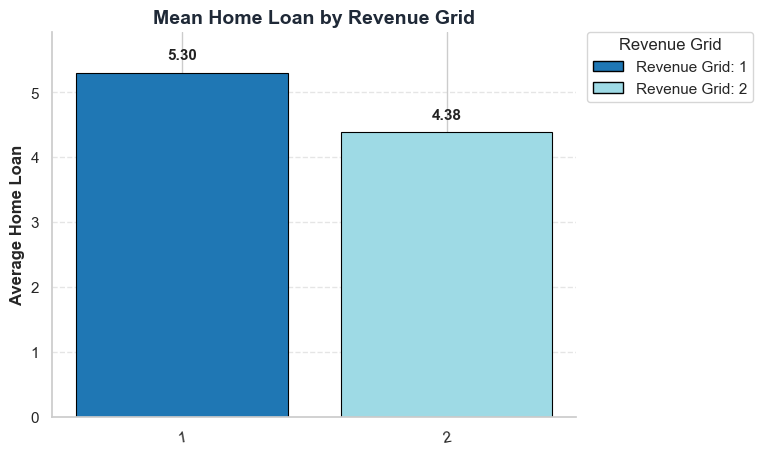

In [126]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

# ---------- CONFIG ----------
column = "Home Loan"        # 👈 target column to visualize
file_path = "Practise Test Case 4 Data.xlsx"
OUT_DIR = "properties"
os.makedirs(OUT_DIR, exist_ok=True)
# ----------------------------

# Load dataset
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# Detect revenue-grid-like target
target_candidates = [c for c in df.columns if c.lower().strip() in 
                     ['revenue grid', 'revenue_grid', 'target', 'label']]
target = target_candidates[0] if target_candidates else df.columns[-1]
df[target] = df[target].astype(str)

# Ensure numeric
if column not in df.columns:
    raise ValueError(f"Column '{column}' not found in dataset.")
df[column] = pd.to_numeric(df[column], errors='coerce')

# Compute group stats
group_means = df.groupby(target)[column].mean().sort_index()
group_stds = df.groupby(target)[column].std().sort_index()
group_counts = df.groupby(target)[column].count().sort_index()
group_sem = group_stds / np.sqrt(group_counts)

# Prepare colors using tab20 (keep same palette)
unique_classes = list(group_means.index)
n = len(unique_classes)
base_palette = plt.cm.tab20(np.linspace(0, 1, max(1, n)))
color_map = {cls: base_palette[i] for i, cls in enumerate(unique_classes)}
colors = [color_map[cls] for cls in unique_classes]

# Plot using matplotlib bar for full control
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(unique_classes))
bars = ax.bar(x, group_means.values, color=colors, edgecolor='black', linewidth=0.8)

# Numeric labels above bars
ymax = group_means.max() if len(group_means) > 0 else 1.0
padding = ymax * 0.12
for xi, val in zip(x, group_means.values):
    ax.text(xi, val + ymax * 0.03, f"{val:.2f}", ha='center', va='bottom', fontsize=11, fontweight='bold', color='#222222')

# Legend: create handles from color_map; place intelligently
handles = [mpatches.Patch(color=color_map[cls], label=f"{target}: {cls}", ec='black') for cls in unique_classes]
if n <= 3:
    # place legend to the right
    ax.legend(handles=handles, title=target, loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=True)
    fig.subplots_adjust(right=0.78)
else:
    # place legend below
    cols = min(n, 4)
    fig.legend(handles=handles, title=target, loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=cols, frameon=True)
    fig.subplots_adjust(bottom=0.22)

# Styling
ax.set_xticks(x)
ax.set_xticklabels(unique_classes, rotation=10, fontsize=11)
ax.set_ylabel(f"Average {column}", fontsize=12, fontweight='bold')
ax.set_title(f"Mean {column} by {target}", fontsize=14, fontweight='bold', color="#1f2937")
ax.set_ylim(0, ymax + padding)
ax.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine(left=False, bottom=False)

# Save figure
out_path = os.path.join(OUT_DIR, "home_loan_by_grid.png")
fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"Saved chart to: {out_path}")

plt.show()


In [148]:
df["children"].unique()

array([ 0.,  1.,  2.,  3., nan])

In [160]:
# /mnt/data/eda_and_modeling_save_model_with_idremoval.py
# Usage: python /mnt/data/eda_and_modeling_save_model_with_idremoval.py

import warnings
warnings.filterwarnings("ignore")

import os, json
from pathlib import Path
import pandas as pd, numpy as np
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score,
                             precision_score, recall_score, f1_score, confusion_matrix, classification_report)
from sklearn.inspection import permutation_importance

# ---------- Config ----------
INPUT_FILE = "mnt/data/Practise Test Case 4 Data.xlsx"
OUT_DIR = "mnt/data"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------- Top-level helper functions & classes (picklable) ----------
def to_str_func(X):
    """
    Convert DataFrame or array-like to pandas DataFrame with string dtype.
    Top-level so it's picklable.
    """
    X_df = pd.DataFrame(X).copy()
    for c in X_df.columns:
        # preserve NaN as 'nan' string temporarily then keep consistent
        X_df[c] = X_df[c].where(X_df[c].notna(), other=np.nan)
        X_df[c] = X_df[c].astype(str)
    return X_df

class RareLabelEncoder(BaseEstimator, TransformerMixin):
    """
    Keep only frequent categories per column (based on min_freq or max_categories).
    During transform, map rare categories to '__OTHER__'.
    """
    def __init__(self, min_freq=0.01, max_categories=None):
        self.min_freq = min_freq
        self.max_categories = max_categories
        self.frequent_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        n = len(X)
        for col in X.columns:
            vc = X[col].astype(str).value_counts(dropna=False)
            if self.min_freq is not None:
                allowed = list(vc[vc / n >= self.min_freq].index.astype(str))
            else:
                allowed = list(vc.index.astype(str))
            if self.max_categories is not None:
                allowed = allowed[:self.max_categories]
            self.frequent_[col] = set(allowed)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            allowed = self.frequent_.get(col, set())
            X[col] = X[col].astype(str).where(X[col].astype(str).isin(allowed), other="__OTHER__")
        return X

def detect_target(df):
    """
    Heuristic to detect binary target column. Returns column name.
    """
    # prefer commonly named columns
    candidates = [c for c in df.columns if any(k in c.lower() for k in ["grid","target","label","class","revenue","segment"])]
    for c in candidates:
        if df[c].nunique() == 2:
            return c
    for c in df.columns:
        nunq = df[c].nunique(dropna=False)
        if nunq == 2 and nunq < len(df) * 0.9:
            return c
    for c in df.columns:
        vals = set(df[c].dropna().unique())
        if vals <= {1,2}:
            return c
    return df.columns[-1]

def find_id_like_columns(df, name_tokens=None, unique_ratio_thresh=0.95):
    """
    Heuristic detection of identifier-like columns based on name tokens or very high uniqueness.
    Returns list of column names to treat as IDs.
    """
    if name_tokens is None:
        name_tokens = ['id', 'ref', 'ref_no', 'refno', 'account', 'acct', 'uuid', 'cust', 'customer', 'serial']
    id_cols = []
    n = len(df)
    for col in df.columns:
        col_low = col.lower()
        name_flag = any(tok in col_low for tok in name_tokens)
        uniq_ratio = df[col].nunique(dropna=False) / float(max(1, n))
        uniq_flag = uniq_ratio >= unique_ratio_thresh
        if name_flag or uniq_flag:
            id_cols.append(col)
    return id_cols

# ---------- Load data ----------
assert os.path.exists(INPUT_FILE), f"Input file not found at {INPUT_FILE}"
xls = pd.ExcelFile(INPUT_FILE)
if len(xls.sheet_names) > 1:
    df = pd.concat([pd.read_excel(xls, sheet_name=s) for s in xls.sheet_names], ignore_index=True)
else:
    df = pd.read_excel(xls)
print("Loaded DataFrame shape:", df.shape)
# replace case-insensitive 'zero' and convert column to numeric, replace NaN with 0
if 'children' in df.columns:
    df['children'] = df['children'].replace(r'^\s*Zero\s*$', 0, regex=True)
    df['children'] = pd.to_numeric(df['children'], errors='coerce').fillna(0).astype(int)

print(df["children"].unique())

# ---------- Detect target and initial mapping ----------
target_col = detect_target(df)
print("Detected target column:", target_col)
y_raw = df[target_col]
unique_vals = sorted(y_raw.dropna().unique())
if set(unique_vals) == {1,2}:
    y = y_raw.map({1:0, 2:1})
elif len(unique_vals) == 2:
    y = y_raw.map({unique_vals[0]: 0, unique_vals[1]: 1})
else:
    y = (y_raw == unique_vals[0]).astype(int)
    print("Warning: used fallback mapping for target.")

# ---------- Identifier detection & removal (audit) ----------
X_full = df.drop(columns=[target_col]).copy()
id_like_cols = find_id_like_columns(X_full, unique_ratio_thresh=0.95)

if id_like_cols:
    id_save_path = os.path.join(OUT_DIR, "removed_identifier_columns.csv")
    X_full[id_like_cols].to_csv(id_save_path, index=False)
    print(f"Saved identifier-like columns to {id_save_path}")
    print("Identifier-like columns detected and removed:", id_like_cols)
else:
    print("No identifier-like columns detected.")
X = X_full.drop(columns=id_like_cols) if id_like_cols else X_full
print("Features used for modeling:", X.shape[1])

# ---------- Basic EDA prints ----------
print("\nEDA summary:")
print("Rows:", len(df))
print("Target distribution:\n", y.value_counts())
print("Target positive rate:", y.mean())
dtype_miss = pd.DataFrame({'dtype': X.dtypes, 'n_missing': X.isna().sum(), 'n_unique': X.nunique(dropna=False)})
print("\nFeature sample (dtype / missing / unique):")
print(dtype_miss.sort_values('n_missing', ascending=False).head(50).to_string())



# ---------- Numeric / Categorical split ----------
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
# treat small-cardinal numeric as categorical
for c in num_cols.copy():
    if X[c].nunique() <= 10:
        num_cols.remove(c)
        cat_cols.append(c)
print(f"\nNumeric cols count: {len(num_cols)}; Categorical cols count: {len(cat_cols)}")

# ---------- Quick correlation & outlier checks ----------
corrs = {}
for c in num_cols:
    try:
        corrs[c] = np.corrcoef(X[c].fillna(X[c].median()), y)[0,1]
    except Exception:
        corrs[c] = np.nan
corrs_series = pd.Series(corrs).sort_values(key=lambda s: s.abs(), ascending=False)
print("\nTop numeric correlations with target:")
print(corrs_series.head(10).to_string())

outlier_summary = []
for c in num_cols:
    s = X[c].dropna()
    if len(s) < 10:
        continue
    q1,q3 = np.percentile(s, [25,75])
    iqr = q3-q1
    lower, upper = q1-1.5*iqr, q3+1.5*iqr
    n_out = ((s < lower) | (s > upper)).sum()
    pct = n_out/len(s)
    if pct > 0.01:
        outlier_summary.append((c, len(s), n_out, pct, lower, upper))
out_df = pd.DataFrame(outlier_summary, columns=['col','n','n_outliers','pct_out','lower','upper']).sort_values('pct_out', ascending=False)
print("\nColumns with >1% IQR outliers (sample):")
print(out_df.head(10).to_string())

# ---------- Preprocessor (robust, picklable) ----------
min_freq = 0.01
max_categories = None

ohe_kwargs = {'handle_unknown': 'ignore'}
try:
    OneHotEncoder(sparse_output=False)
    ohe_kwargs['sparse_output'] = False
except TypeError:
    ohe_kwargs['sparse'] = False

categorical_transformer = Pipeline(steps=[
    ('rare', RareLabelEncoder(min_freq=min_freq, max_categories=max_categories)),
    ('to_str', FunctionTransformer(to_str_func, validate=False)),   # picklable top-level function
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('onehot', OneHotEncoder(**ohe_kwargs))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# ---------- Train/Val/Test split (stratified) ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42)
print(f"\nData splits - train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")

# Save test set for audit (includes original removed ID columns if you want to join later)
test_out = X_test.copy()
test_out[target_col] = y_test.values
test_csv_path = os.path.join(OUT_DIR, "test_set_saved.csv")
test_out.to_csv(test_csv_path, index=False)
print("Saved test set to:", test_csv_path)

# ---------- Model candidates & hyperparameter search ----------
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
n_iter_search = 40

candidates = {
    "logreg": {
        "pipeline": Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=2000, solver='liblinear'))]),
        "params": {'clf__C': np.logspace(-3,3,20), 'clf__penalty': ['l1','l2']}
    },
    "rf": {
        "pipeline": Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))]),
        "params": {'clf__n_estimators': [100,200,400], 'clf__max_depth': [None,5,10,20], 'clf__min_samples_split': [2,5,10], 'clf__min_samples_leaf': [1,2,4]}
    }
}

results = {}
best_models = {}
for name, cfg in candidates.items():
    print(f"\n--- Running RandomizedSearchCV for {name} ---")
    pipe = cfg['pipeline']
    params = cfg['params']
    rsearch = RandomizedSearchCV(pipe, params, n_iter=n_iter_search, scoring='roc_auc',
                                 n_jobs=-1, cv=cv, random_state=42, verbose=1, error_score='raise')
    try:
        rsearch.fit(X_train, y_train)
    except Exception as e:
        print(f"Training for {name} failed: {e}")
        continue
    best = rsearch.best_estimator_
    best_models[name] = best
    joblib.dump(best, os.path.join(OUT_DIR, f"model_{name}.joblib"))
    print(f"Saved tuned model to {os.path.join(OUT_DIR, f'model_{name}.joblib')}")
    # validation eval
    if hasattr(best, "predict_proba"):
        y_val_proba = best.predict_proba(X_val)[:,1]
    else:
        y_val_proba = best.decision_function(X_val)
    y_val_pred = (y_val_proba >= 0.5).astype(int)
    metrics = {
        'roc_auc': float(roc_auc_score(y_val, y_val_proba)),
        'pr_auc': float(average_precision_score(y_val, y_val_proba)),
        'accuracy': float(accuracy_score(y_val, y_val_pred)),
        'precision': float(precision_score(y_val, y_val_pred, zero_division=0)),
        'recall': float(recall_score(y_val, y_val_pred, zero_division=0)),
        'f1': float(f1_score(y_val, y_val_pred, zero_division=0))
    }
    results[name] = {'best_params': rsearch.best_params_, 'metrics': metrics}
    print("Validation metrics:", metrics)

if not results:
    raise RuntimeError("All model trainings failed. Check data/pipeline.")

# pick best by validation ROC-AUC
best_name = max(results.items(), key=lambda kv: kv[1]['metrics']['roc_auc'])[0]
best_model = best_models[best_name]
print("\nSelected best model:", best_name)
print("Validation metrics:", results[best_name]['metrics'])

# ---------- Evaluate best model on test ----------
if hasattr(best_model, "predict_proba"):
    y_test_proba = best_model.predict_proba(X_test)[:,1]
else:
    y_test_proba = best_model.decision_function(X_test)
y_test_pred = (y_test_proba >= 0.5).astype(int)
test_metrics = {
    'roc_auc': float(roc_auc_score(y_test, y_test_proba)),
    'pr_auc': float(average_precision_score(y_test, y_test_proba)),
    'accuracy': float(accuracy_score(y_test, y_test_pred)),
    'precision': float(precision_score(y_test, y_test_pred, zero_division=0)),
    'recall': float(recall_score(y_test, y_test_pred, zero_division=0)),
    'f1': float(f1_score(y_test, y_test_pred, zero_division=0))
}
print("\nTest metrics:", test_metrics)
print(classification_report(y_test, y_test_pred, zero_division=0))

# ---------- Feature importance (permutation if not tree) ----------
preprocessor.fit(X_train)
num_feature_names = num_cols
cat_feature_names = []
if cat_cols:
    try:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    except Exception:
        cat_feature_names = [f"{c}__v" for c in cat_cols]
feature_names = num_feature_names + cat_feature_names

fi_series = None
try:
    clf = best_model.named_steps['clf']
    if hasattr(clf, 'feature_importances_'):
        fi_series = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
except Exception:
    fi_series = None

if fi_series is None:
    print("Computing permutation importance (on validation)...")
    perm = permutation_importance(best_model, X_val, y_val, n_repeats=20, random_state=42, n_jobs=-1)
    importances = perm.importances_mean
    if len(importances) == len(feature_names):
        fi_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    else:
        fi_series = pd.Series(importances).sort_values(ascending=False)

print("\nTop features by importance:")
print(fi_series.head(20).to_string())

# ---------- Save artifacts ----------
best_model_path = os.path.join(OUT_DIR, "best_model.joblib")
joblib.dump(best_model, best_model_path)
print("Saved best pipeline to:", best_model_path)

preproc_path = os.path.join(OUT_DIR, "preprocessor.joblib")
joblib.dump(preprocessor, preproc_path)
print("Saved preprocessor to:", preproc_path)

artifacts = {
    'test_csv': test_csv_path,
    'best_model': best_model_path,
    'preprocessor': preproc_path,
    'candidate_models': [os.path.join(OUT_DIR, f"model_{k}.joblib") for k in best_models.keys()],
    'selected_model_name': best_name,
    'target_col': target_col,
    'numeric_columns': num_cols,
    'categorical_columns': cat_cols,
    'removed_identifier_columns_csv': id_save_path if id_like_cols else None
}
with open(os.path.join(OUT_DIR, "artifacts_summary.json"), "w") as f:
    json.dump(artifacts, f, indent=2)

findings = {
    'n_rows': int(len(df)),
    'n_features': int(X.shape[1]),
    'target_positive_rate': float(y.mean()),
    'top_correlated_features': corrs_series.head(10).to_dict(),
    'best_model': best_name,
    'best_model_val_metrics': results[best_name]['metrics'],
    'best_model_test_metrics': test_metrics
}
with open(os.path.join(OUT_DIR, "findings_summary.json"), "w") as f:
    json.dump(findings, f, indent=2)

print("\nAll done. Artifacts saved under /mnt/data/")


Loaded DataFrame shape: (10155, 31)
[0 1 2 3]
Detected target column: Revenue Grid
Saved identifier-like columns to mnt/data/removed_identifier_columns.csv
Identifier-like columns detected and removed: ['REF_NO', 'post_code']
Features used for modeling: 28

EDA summary:
Rows: 10155
Target distribution:
 Revenue Grid
1    9069
0    1086
Name: count, dtype: int64
Target positive rate: 0.8930576070901034

Feature sample (dtype / missing / unique):
                                   dtype  n_missing  n_unique
children                           int64          0         4
age_band                          object          0        13
Investment in Derivative         float64          0      3796
Investment in Equity             float64          0      3250
Investment in Commodity          float64          0      3558
region                            object          0        13
gender                            object          0         3
Online Purchase Amount           float64          0    

In [162]:
# predict_random_20_from_test.py
# Usage: python /mnt/data/predict_random_20_from_test.py
# This script loads 20 random rows from test_set_saved.csv and predicts using best_model.joblib

import pandas as pd
import numpy as np
import joblib
import os

# --- Paths ---
TEST_PATH = "mnt/data/test_set_saved.csv"
MODEL_PATH = "mnt/data/best_model.joblib"
OUTPUT_PATH = "mnt/data/test_predictions_sample.csv"

# --- Load data & model ---
assert os.path.exists(TEST_PATH), f"Test CSV not found: {TEST_PATH}"
assert os.path.exists(MODEL_PATH), f"Model file not found: {MODEL_PATH}"

print("Loading test data and model...")
df_test = pd.read_csv(TEST_PATH)
model = joblib.load(MODEL_PATH)  # This is the full pipeline (preprocessor + classifier)

# --- Detect target column and features ---
target_candidates = [c for c in df_test.columns if any(k in c.lower() for k in ["revenue grid"])]
target_col = target_candidates[0] if target_candidates else df_test.columns[-1]
print("Detected target column:", target_col)

X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col] if target_col in df_test.columns else None

# --- Sample 20 random rows ---
np.random.seed(42)  # reproducible
sample_df = X_test.sample(n=200, random_state=42)
print("Selected 20 random rows for prediction.")

# --- Predict ---
if hasattr(model, "predict_proba"):
    probas = model.predict_proba(sample_df)[:, 1]
else:
    probas = model.decision_function(sample_df)

preds = (probas >= 0.5).astype(int)

# --- Combine with original rows ---
output_df = sample_df.copy()
output_df["Predicted_Probability"] = probas
output_df["Predicted_Class"] = preds + 1

# Optionally, if ground truth exists in test CSV, add it for comparison
if y_test is not None:
    output_df["Actual_Class"] = y_test.loc[sample_df.index].values + 1

# --- Save output ---
output_df.to_csv(OUTPUT_PATH, index=False)
print(f"\nPredictions saved to: {OUTPUT_PATH}")
print(output_df.head(200))


Loading test data and model...
Detected target column: Revenue Grid
Selected 20 random rows for prediction.

Predictions saved to: mnt/data/test_predictions_sample.csv
      children age_band                status         occupation  \
692          0    65-70               Partner            Retired   
986          0    61-65  Single/Never Married            Retired   
552          0    55-60               Partner       Professional   
596          0    45-50               Partner  Secretarial/Admin   
1965         2    31-35               Partner       Professional   
...        ...      ...                   ...                ...   
374          0    36-40  Single/Never Married       Professional   
247          3    26-30    Divorced/Separated              Other   
1424         0    45-50               Partner  Secretarial/Admin   
344          2    41-45               Partner   Business Manager   
1105         1    61-65               Widowed            Retired   

     occupation

In [164]:
np.array(output_df['Predicted_Class'])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [166]:
np.array(output_df['Actual_Class'])

array([2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])